# Loading in xray data from exp (55Fe x-rays on SCA 20663)

In [1]:
# %%
%matplotlib widget  
# Turn ON notebook and OFF inline and ipympl when running on OSC
#%matplotlib notebook
#%matplotlib inline 
#%matplotlib ipympl

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import scipy.optimize as opt
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
from scipy.ndimage import sum as ndi_sum
from scipy.ndimage import maximum_filter
from scipy.ndimage import binary_dilation
from astropy.stats import sigma_clipped_stats
from matplotlib.patches import Polygon, Rectangle
from scipy.ndimage import binary_dilation, label, center_of_mass
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.ndimage import label
from pathlib import Path

try:
    here = Path(__file__).parent
except NameError:
    # __file__ doesn't exist in notebooks or interactive sessions
    here = Path.cwd()
fits_path = here / '20190919_95k_1p1m0p1_fe55_20663_003_diff.fits'  # ← replace with your actual filename

with fits.open(fits_path) as hdulist:
    # hdulist is a list of HDU (Header/Data Unit) objects
    primary_hdu = hdulist[0]
    data = primary_hdu.data      # NumPy array of your image/spectrum/whatever
    header = primary_hdu.header  # FITS header metadata

print(f"Data shape: {data.shape}")
print("Header keys:", list(header.keys())[:10])


c:\Users\Owner\anaconda3\envs\8820-env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Data shape: (100, 4096, 4096)
Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NAXIS3', 'EXTEND']


In [2]:
#enter number of available cores
num_of_cores = os.cpu_count() + 4

#X-ray energy (in eV)
xray_en = 5898.75

#data dimensions
Nframe, h, w = data.shape

def compute_mask_med_frame(data, sigma_mult):
    print("⏳ Finding hot pixels…")
    median_img = np.median(data, axis=0)
    mad        = np.median(np.abs(median_img - np.median(median_img)))
    sigma_est  = 1.4826 * mad
    thresh_med = np.median(median_img) + sigma_mult * sigma_est
    mask_med   = median_img > thresh_med
    print(f"✅ Done looking for hot pixels (σ={sigma_est:.3f}, thresh={thresh_med:.1f})")
    return mask_med

def compute_mask_first_frame(data, sigma_mult):
    print("⏳ Finding very hot pixels…")
    first_img  = data[0]
    med_first  = np.median(first_img)
    mad_first  = np.median(np.abs(first_img - med_first))
    sigma_est  = 1.4826 * mad_first
    thresh0    = med_first + sigma_mult * sigma_est
    mask0      = first_img > thresh0
    print(f"✅ Done looking for very hot pixels (σ={sigma_est:.3f}, thresh={thresh0:.1f})")
    return mask0

def compute_mask_no_response(data, sat_cut):
    print("⏳ Finding non-responsive pixels…")
    # If you wanted a row-wise tqdm you could replace the next line with a loop + tqdm
    frame_diff = np.abs(np.diff(data, axis=0))       # (Nframe-1, 4096,4096)
    med_diff   = np.median(frame_diff, axis=0)
    mask_non_res   = med_diff < sat_cut
    print(f"✅ Done looking for non-responsive pixesls (median(med_diff)={np.median(med_diff):.3e})")
    return mask_non_res

# parameters
sigma_mult = 9.8
sat_cut     = 5.999

print(f"Number of cores available for parallelization = {num_of_cores - 4}")
# launch all three in parallel
with ThreadPoolExecutor(max_workers=num_of_cores) as exe:
    futures = {
        exe.submit(compute_mask_med_frame,  data, sigma_mult): 'med',
        exe.submit(compute_mask_first_frame, data, sigma_mult): 'first',
        exe.submit(compute_mask_no_response, data, sat_cut):     'sat',
    }
    # just iterate to let each print when done
    for fut in as_completed(futures):
        _name = futures[fut]
        # could inspect fut.result() here if you wanted to check for errors

mask_hot = [f for f,n in futures.items() if n=='med'][0].result()
mask_veryhot  = [f for f,n in futures.items() if n=='first'][0].result()
mask_non_res = [f for f,n in futures.items() if n=='sat'][0].result()

print("🔗 Combining masks into one boolean array…")
base_mask = mask_hot | mask_veryhot | mask_non_res

# create a mask for pixels adjacent to a pixel with flagged response: any neighbor of the base_mask
print("⏳ Finding all adjacent pixels…")
mask_adj  = binary_dilation(base_mask, structure=np.ones((3,3)), border_value=0) & ~base_mask
maskArray = base_mask | mask_adj
print("✅ Done with adjacent pixel mask")

print("🔗 Combining all masks into final array…")
print("🎉 maskArray ready, shape =", maskArray.shape)

print("Comparing to percentages from Hirata, 2024, Table 2:")
# fractions in percent
frac_non_res   = mask_non_res.mean()   * 100  # mask.mean() = mask.sum() / mask.size
frac_hot   = mask_hot.mean()   * 100  
frac_veryhot = mask_veryhot.mean()       * 100  
frac_adj = mask_adj.mean() * 100
frac_all   = maskArray.mean()   * 100  # union 

print(f"Non-resp pixels: {frac_non_res:.2f}% (vs. 0.53% in literature)")
print(f"Hot pixels: {frac_hot:.2f}% (vs. 0.20% in literature)")
print(f"Very hot pixels: {frac_veryhot:.2f}% (vs. 0.11% in literature)")
print(f"Adjacent pixels: {frac_adj:.2f}% (vs. 2.47% in literature)")
print(f"Union:       {frac_all:.2f}%  (vs. 3.01% in literature)")

Number of cores available for parallelization = 8
⏳ Finding hot pixels…
⏳ Finding very hot pixels…
⏳ Finding non-responsive pixels…
✅ Done looking for very hot pixels (σ=8.896, thresh=86.2)
✅ Done looking for hot pixels (σ=0.741, thresh=7.3)
✅ Done looking for non-responsive pixesls (median(med_diff)=1.000e+01)
🔗 Combining masks into one boolean array…
⏳ Finding all adjacent pixels…
✅ Done with adjacent pixel mask
🔗 Combining all masks into final array…
🎉 maskArray ready, shape = (4096, 4096)
Comparing to percentages from Hirata, 2024, Table 2:
Non-resp pixels: 0.38% (vs. 0.53% in literature)
Hot pixels: 0.40% (vs. 0.20% in literature)
Very hot pixels: 0.11% (vs. 0.11% in literature)
Adjacent pixels: 3.10% (vs. 2.47% in literature)
Union:       3.90%  (vs. 3.01% in literature)


Number of very hot pixels =  17769
Number of hot pixels =  66476
Number of non-responsive pixels =  64482
Number of adjacent pixels =  520563
Total number of unusable pixels =  654888


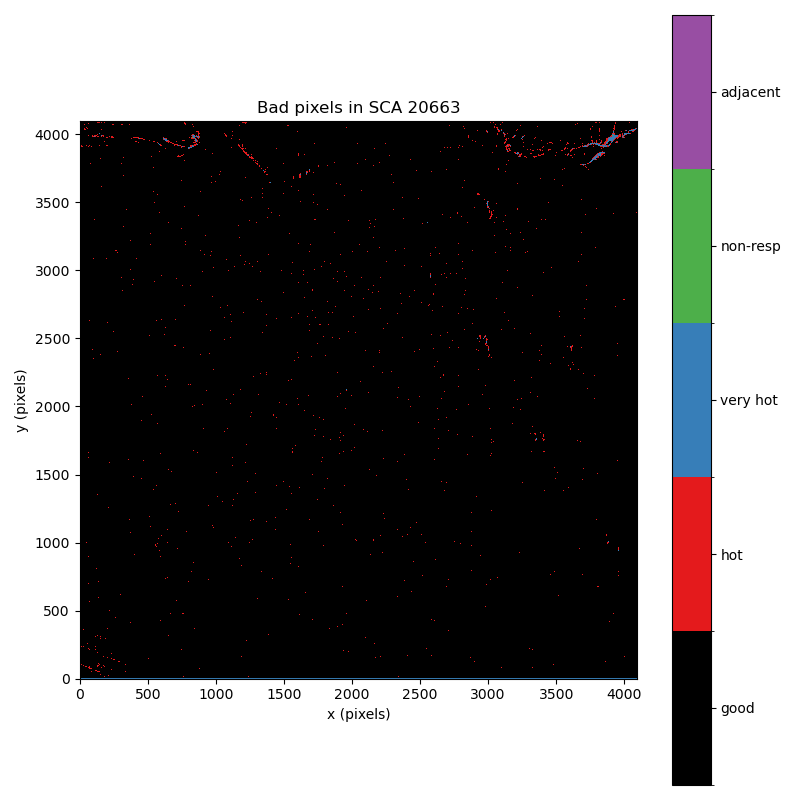

In [3]:
very_hot_pix = np.count_nonzero(mask_veryhot)
hot_pix = np.count_nonzero(mask_hot)
non_res_pix = np.count_nonzero(mask_non_res)
adj_pix = np.count_nonzero(mask_adj)
all_bad_pix = np.count_nonzero(maskArray)

print("Number of very hot pixels = ", very_hot_pix)
print("Number of hot pixels = ", hot_pix)
print("Number of non-responsive pixels = ", non_res_pix)
print("Number of adjacent pixels = ", adj_pix)
print("Total number of unusable pixels = ", all_bad_pix)

labels = np.zeros((h, w), dtype=int)
labels[mask_hot]     = 1
labels[mask_veryhot] = 2
labels[mask_non_res] = 3
labels[mask_adj]     = 4

cmap = mpl.colors.ListedColormap([
    "#000000",  # 0 = good pixels (black) 
    "#e41a1c",  # 1 = hot         (red)
    "#377eb8",  # 2 = very hot    (blue)
    "#4daf4a",  # 3 = non-resp    (green)
    "#984ea3",  # 4 = adjacent    (purple)
])
# make boundaries at ints 0–5
norm = mpl.colors.BoundaryNorm(np.arange(6), cmap.N)

plt.figure(figsize=(8, 8))
im = plt.imshow(labels, origin="lower", cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ticks=[0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_yticklabels([
    "good", "hot", "very hot", "non-resp", "adjacent"
])
plt.title("Bad pixels in SCA 20663")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.tight_layout()
plt.show()

Found 57637 xray & cosmic‐ray‐like peaks with ≥5.0 σ cut (per-frame thresholds below):


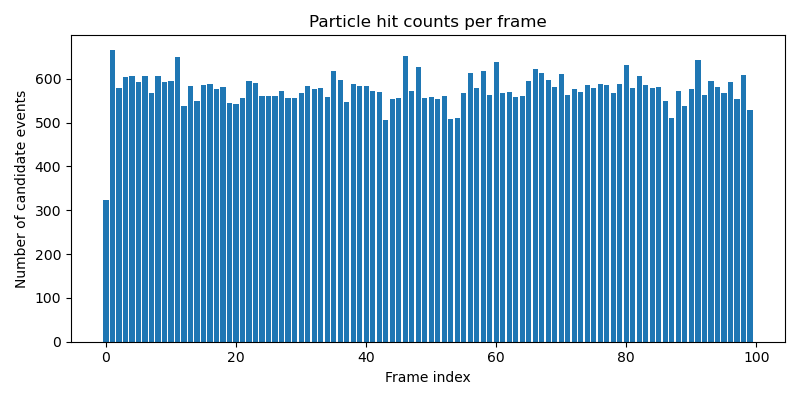

In [4]:
sigma_thresh   = 5.01
mask_expanded  = maximum_filter(maskArray.astype(int), size=5) > 0

def find_peaks_for_frame(iframe, sigma_thresh):
    image   = data[iframe]
    _, med, _ = sigma_clipped_stats(image, sigma=3.0, maxiters=5)
    mad     = np.median(np.abs(image - med))
    sigma_e = mad * 1.4826
    threshold = med + sigma_thresh * sigma_e

    local_max = maximum_filter(image, size=3)
    cand      = (image == local_max) & (~mask_expanded) & (image > threshold)

    ys, xs = np.where(cand)
    peaks  = [(iframe, int(y), int(x)) for y, x in zip(ys, xs)]
    return peaks, threshold

if __name__ == "__main__":

    # 1) run in parallel, get a list of (peaks, threshold) tuples
    with ThreadPoolExecutor(max_workers=num_of_cores) as executor:
        results = list(executor.map(
            find_peaks_for_frame,
            range(Nframe),
            [sigma_thresh] * Nframe
        ))

    # 2) unzip them into two lists
    all_frame_peaks, thresholds = zip(*results)
    #    all_frame_peaks is a tuple of length Nframe, each entry is the peaks list
    #    thresholds        is a tuple of length Nframe, each entry is that frame’s threshold

    # 3) now do your “previous‐frame” filtering exactly as before
    filtered_events = []
    for f, peaks in enumerate(all_frame_peaks):
        prev_f = (f - 1) % Nframe
        prev_pos = {(y, x) for (_, y, x) in all_frame_peaks[prev_f]}
        for (_, y, x) in peaks:
            if (y, x) not in prev_pos:
                filtered_events.append((f, y, x))

    events = np.array(filtered_events, dtype=int)
    print(f"Found {len(events)} xray & cosmic‐ray‐like peaks "
          f"with ≥{sigma_thresh:.1f} σ cut (per-frame thresholds below):")

    # 4) if you want, print out each frame’s threshold:
    #for f, thr in enumerate(thresholds):
        #print(f"  frame {f:3d}: threshold = {thr:.1f}")

        # count how many hits in each frame
counts = np.bincount(events[:,0], minlength=data.shape[0])

plt.figure(figsize=(8,4))
plt.bar(np.arange(len(counts)), counts)
plt.xlabel("Frame index")
plt.ylabel("Number of candidate events")
plt.title("Particle hit counts per frame")
plt.tight_layout()
plt.show()

In [5]:
def merge_peaks(events, data, proximity_radius=2, max_workers=num_of_cores):
    """
    Merge spatially adjacent peaks within each frame.

    Parameters
    ----------
    events : (M, 3)-ndarray of int
        List of (frame, y, x) peaks you've already found.
    data : ndarray, shape (Nframe, h, w)
        Your full data cube, needed for intensity weighting.
    proximity_radius : int
        Merge any two peaks whose pixel-centers are within
        `proximity_radius` in Chebyshev distance.

    Returns
    -------
    merged : (K,3)-ndarray of int
        New list of (frame, y, x), one per merged object.
    """

    # Pre-bucket original peaks by frame for O(1) lookup
    events_by_frame = {
        f: events[events[:,0] == f, 1:]
        for f in np.unique(events[:,0])
    }

    # A 3×3 struct for the actual label() call
    small_struct = np.ones((3,3), dtype=bool)
    # The large footprint we use for dilation
    big_struct   = np.ones((2*proximity_radius+1,
                            2*proximity_radius+1), dtype=bool)

    def process_frame(f):
        coords = events_by_frame.get(f)
        if coords is None or len(coords)==0:
            return []

        # build a 1-pixel mask of your raw hits
        mask = np.zeros((h, w), bool)
        mask[coords[:,0], coords[:,1]] = True

        # dilate by the big_struct so any hits within r pixels merge
        mask_dil = binary_dilation(mask, structure=big_struct)

        # now label the dilated mask with the 3×3 struct
        labeled, ncomp = label(mask_dil, structure=small_struct)

        # figure out which original coords belong to which label
        labels_at_peaks = labeled[coords[:,0], coords[:,1]]

        merged = []
        for lab in range(1, ncomp+1):
            inds = np.where(labels_at_peaks == lab)[0]
            cluster = coords[inds]   # all (y,x) in this cluster

            if len(cluster)==1:
                y0, x0 = cluster[0]
            else:
                # intensity‐weighted centroid over the ORIGINAL points
                ys = cluster[:,0].astype(float)
                xs = cluster[:,1].astype(float)
                ws = data[f, ys.astype(int), xs.astype(int)].astype(float)
                y0 = int(round(np.average(ys, weights=ws)))
                x0 = int(round(np.average(xs, weights=ws)))

            merged.append((f, y0, x0))

        return merged

    # dispatch in parallel
    merged = []
    with ThreadPoolExecutor(max_workers=max_workers) as exe:
        for sub in exe.map(process_frame, range(Nframe)):
            merged.extend(sub)

    return np.array(merged, dtype=int)

merged_events = merge_peaks(events, data)
events_difference = len(events) -len(merged_events)

print(f"{len(events)} → {len(merged_events)} merged events, a difference of {events_difference}")

57637 → 57284 merged events, a difference of 353


<IPython.core.display.Javascript object>


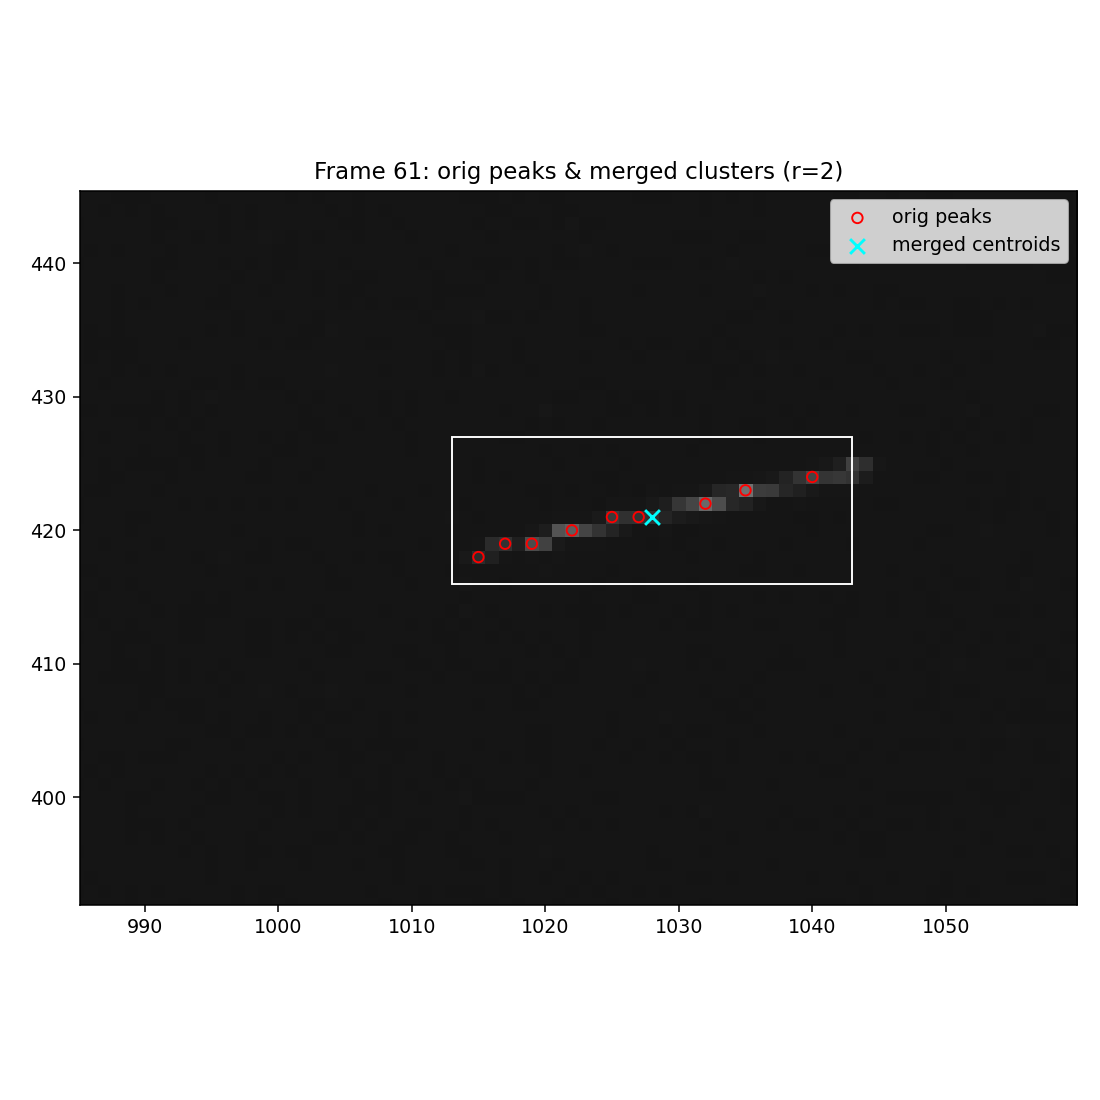

In [7]:
def plot_mergers(frame, events, merged_events, data, proximity_radius=2):
    """
    Show original peaks vs. merged clusters for a single frame,
    drawing red circles on the raw hits, cyan x’s at merged centroids,
    and white rectangles around each dilated cluster (r=proximity_radius).
    """
    img = data[frame]

    # 1) pick out this frame’s original and merged points
    orig   = events[events[:,0] == frame][:, 1:]
    merged = merged_events[merged_events[:,0] == frame][:, 1:]

    # 2) build a 1-pixel mask of the raw hits
    mask = np.zeros((h, w), dtype=bool)
    for y, x in orig:
        mask[y, x] = True

    # 3) dilate by your big footprint
    big_struct = np.ones((2*proximity_radius+1,
                          2*proximity_radius+1), dtype=bool)
    mask_dil = binary_dilation(mask, structure=big_struct)

    # 4) label that dilated mask with a 3×3 struct
    small_struct = np.ones((3,3), dtype=bool)
    labeled, ncomp = label(mask_dil, structure=small_struct)

    # 5) plot background
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img, cmap='gray', origin='lower')

    # 6) overlay raw peaks
    if len(orig):
        ys, xs = orig[:,0], orig[:,1]
        ax.scatter(xs, ys,
                   s=30, facecolors='none', edgecolors='red',
                   label='orig peaks')

    # 7) overlay merged centroids
    if len(merged):
        ym, xm = merged[:,0], merged[:,1]
        ax.scatter(xm, ym,
                   s=60, marker='x', color='cyan',
                   label='merged centroids')

    # 8) draw white rectangles around each dilated cluster
    for lab in range(1, ncomp+1):
        coords = np.argwhere(labeled == lab)
        y0, y1 = coords[:,0].min(), coords[:,0].max()
        x0, x1 = coords[:,1].min(), coords[:,1].max()
        width  = x1 - x0 + 1
        height = y1 - y0 + 1

        rect = Rectangle((x0, y0),
                         width, height,
                         fill=False,
                         edgecolor='white',
                         linewidth=1)
        ax.add_patch(rect)

    ax.set_title(f'Frame {frame}: orig peaks & merged clusters (r={proximity_radius})')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

plot_mergers(frame=61, events=events, merged_events=merged_events, data=data)    

<IPython.core.display.Javascript object>


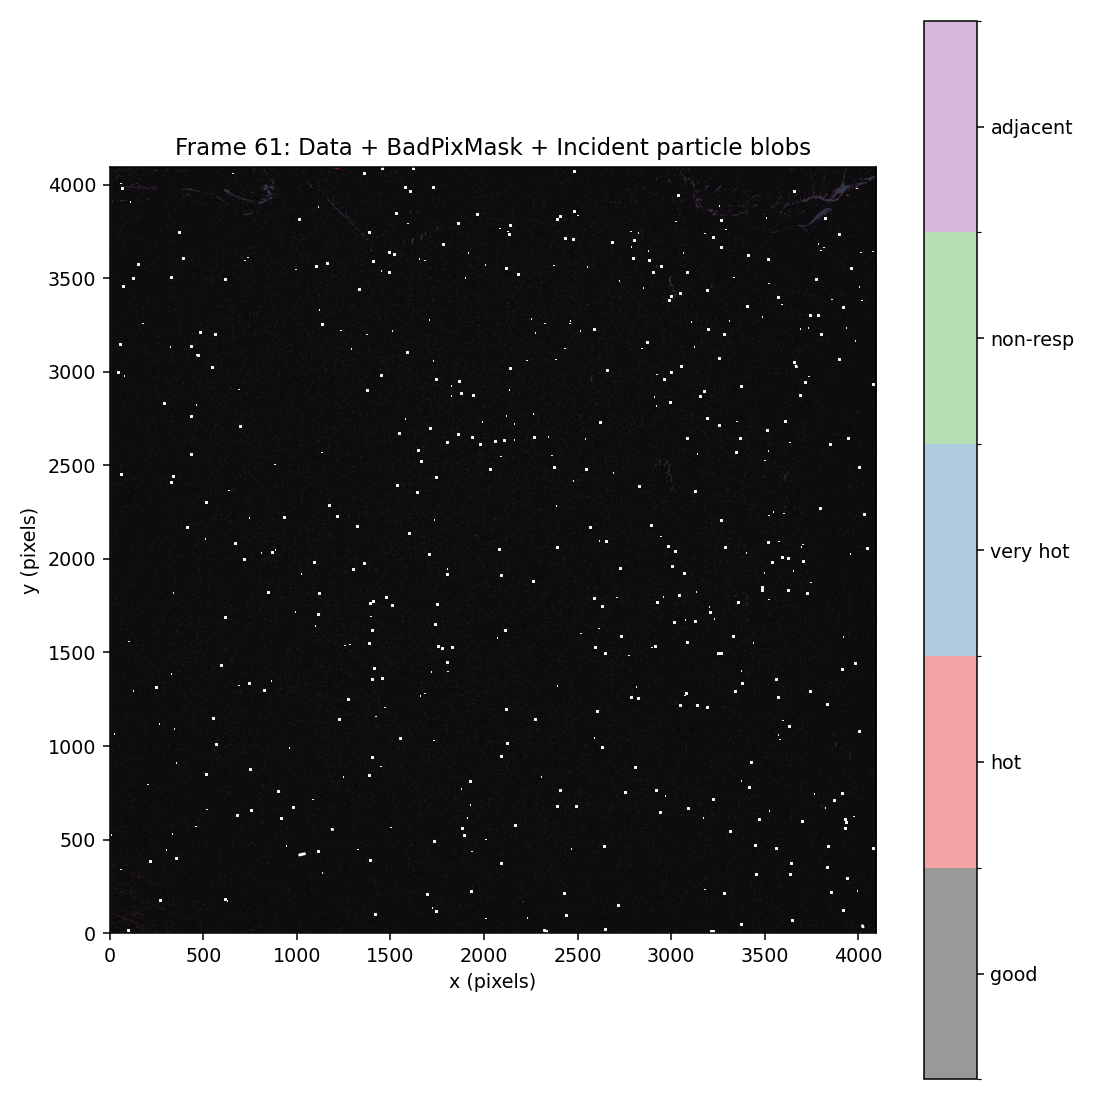

In [6]:
# parameters
frame = 61
proximity_radius = 2

# — build your 4-class mask label image as before —
labels = np.zeros((h, w),     dtype=int)
labels[mask_hot]     = 1
labels[mask_veryhot] = 2
labels[mask_non_res] = 3
labels[mask_adj]     = 4

cmap = mpl.colors.ListedColormap([
    "#000000",  # 0 good
    "#e41a1c",  # 1 hot
    "#377eb8",  # 2 very hot
    "#4daf4a",  # 3 non-resp
    "#984ea3",  # 4 adjacent
])
norm = mpl.colors.BoundaryNorm(np.arange(6), cmap.N)

# — reconstruct your dilated clusters for this frame —
orig = events[events[:,0] == frame][:,1:]   # (y,x) of raw hits
mask_peaks = np.zeros((h,w), bool)
mask_peaks[orig[:,0], orig[:,1]] = True

big_struct = np.ones((2*proximity_radius+1,)*2, dtype=bool)
mask_dil   = binary_dilation(mask_peaks, structure=big_struct)

# now label that with a 3×3
labeled, ncomp = label(mask_dil, structure=np.ones((3,3), bool))

# — plot everything —
fig, ax = plt.subplots(figsize=(8,8))

# 1) raw data
ax.imshow(data[frame], cmap='gray', origin='lower')

# 2) mask classes, semi-transparent
im = ax.imshow(labels, origin='lower', cmap=cmap, norm=norm, alpha=0.4)
cbar = fig.colorbar(im, ticks=[0.5,1.5,2.5,3.5,4.5], ax=ax)
cbar.ax.set_yticklabels(["good","hot","very hot","non-resp","adjacent"])

# 3) convex‐hull blobs (or tiny boxes for 1–2 pixel clusters)
for lab in range(1, ncomp+1):
    pts = np.argwhere(labeled == lab)  # array of [[y,x],...]
    if len(pts) >= 3:
        hull = ConvexHull(pts)
        hull_pts = pts[hull.vertices]      # still [[y,x],...]
        # flip to (x,y) for plotting
        poly = Polygon(hull_pts[:, ::-1],
                       fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(poly)
    else:
        # fallback box
        y0, y1 = pts[:,0].min(), pts[:,0].max()
        x0, x1 = pts[:,1].min(), pts[:,1].max()
        rect = Rectangle((x0, y0),
                         x1-x0+1, y1-y0+1,
                         fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(rect)

ax.set_title(f"Frame {frame}: Data + BadPixMask + Incident particle blobs")
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
plt.tight_layout()
plt.show()


In [6]:
# Freudenburg et al. gain
gain = 1.6232  # electrons per DN

def prep_frame(f, min_size=2):
    img = data[f].astype(np.float64)
    _, med, _  = sigma_clipped_stats(img, sigma=3.0, maxiters=15)
    mad        = np.median(np.abs(img - med))
    sigma_est  = mad * 1.4826
    thresh     = med + sigma_thresh * sigma_est

    binary     = img > thresh
    labels_tmp, _ = label(binary)
    counts     = np.bincount(labels_tmp.ravel())
    keep       = np.where(counts >= min_size)[0]
    clean      = np.isin(labels_tmp, keep)
    labels_fp, _ = label(clean)
    return f, med, labels_fp

# 1) Parallel‐compute your medians[] and footprint labels_list[]
medians     = np.zeros(Nframe, dtype=float)
labels_list = [None] * Nframe

with ThreadPoolExecutor(max_workers=num_of_cores) as exe:
    futures = [exe.submit(prep_frame, f) for f in range(Nframe)]
    for fut in as_completed(futures):
        f, med, labels_fp = fut.result()
        medians[f]        = med
        labels_list[f]    = labels_fp

# -----------------------------------------------------------------------------
# 2) Build an index of which events live in each frame
# -----------------------------------------------------------------------------
# events is an (M,3) array: [frame, y, x]
event_idxs = {
    f: np.where(merged_events[:,0] == f)[0]
    for f in np.unique(merged_events[:,0])
}

# structuring elements
proximity_radius = 2  # or whatever you choose
big_struct   = np.ones((2*proximity_radius+1,)*2, dtype=bool)
small_struct = np.ones((3,3), dtype=bool)

# containers for per-frame blob sums/counts
blob_sums     = {}
blob_counts   = {}
hit_blob_label = np.zeros(len(merged_events), dtype=int)

# -----------------------------------------------------------------------------
# 3) Frame‐by‐frame “blob” computation
# -----------------------------------------------------------------------------
for f, idxs in event_idxs.items():
    # a) raw‐hit mask
    coords     = merged_events[idxs,1:].astype(int)  # (k,2)
    mask_peaks = np.zeros((h,w), bool)
    mask_peaks[coords[:,0], coords[:,1]] = True

    # b) dilate & label
    dil         = binary_dilation(mask_peaks, structure=big_struct)
    lab_img, n_blobs = label(dil, structure=small_struct)

    # c) background‐subtracted image
    img    = data[f].astype(np.float64)
    med    = medians[f]
    im_corr = img - med

    # d) sums & counts per blob‐label
    labels_idx    = np.arange(1, n_blobs+1)
    sums   = ndi_sum(im_corr, lab_img, labels_idx)
    counts = ndi_sum(np.ones_like(im_corr), lab_img, labels_idx).astype(int)

    blob_sums[f]   = sums
    blob_counts[f] = counts

    # e) assign each raw‐hit to a blob
    hit_blob_label[idxs] = lab_img[coords[:,0], coords[:,1]]

# -----------------------------------------------------------------------------
# 4) augment events → events_aug with blob_label as 4th column
# -----------------------------------------------------------------------------
events_aug = np.column_stack((merged_events, hit_blob_label))

# -----------------------------------------------------------------------------
# 5) rewritten process_hit that also pulls from blob_sums/blob_counts
# -----------------------------------------------------------------------------
def process_hit(hit):
    f, y, x, blob_lab = hit.astype(int)
    img       = data[f].astype(np.int32)
    med       = medians[f]
    labels_fp = labels_list[f]

    # --- your 3×3 sum ---
    y0, y1   = max(y-1,0), min(y+2,h)
    x0, x1   = max(x-1,0), min(x+2,w)
    sum3     = img[y0:y1, x0:x1].sum()

    # --- your 5×5 sum ---
    y0_5, y1_5 = max(y-2,0), min(y+3,h)
    x0_5, x1_5 = max(x-2,0), min(x+3,w)
    sum5       = img[y0_5:y1_5, x0_5:x1_5].sum()

    # --- footprint sum (old method) ---
    #region_fp    = (labels_fp == labels_fp[y,x])
    #sum_fp_DN    = img[region_fp].sum() - med * region_fp.sum()

    # --- now the new “blob” sums & counts ---
    s_arr        = blob_sums[f]
    c_arr        = blob_counts[f]
    sum_blob_DN  = int(s_arr[blob_lab-1])
    n_pix_blob   = int(c_arr[blob_lab-1])

    return {
        'frame':      int(f),
        'y':          int(y),
        'x':          int(x),
        'sum3x3_DN':  int(sum3),
        'sum3x3_e⁻':  sum3 * gain,
        'sum5x5_DN':  int(sum5),
        'sum5x5_e⁻':  sum5 * gain,
        'blob_label': int(blob_lab),
        'blob_DN':    sum_blob_DN,
        'blob_e⁻':    sum_blob_DN * gain,
        'n_pix_blob': n_pix_blob,
    }

# -----------------------------------------------------------------------------
# 6) Parallel hit‐processing over events_aug → DataFrame
# -----------------------------------------------------------------------------
with ThreadPoolExecutor(max_workers=num_of_cores) as exe:
    rows = list(exe.map(process_hit, events_aug))

df = pd.DataFrame(rows)
print(df.head())

   frame   y     x  sum3x3_DN  sum3x3_e⁻  sum5x5_DN  sum5x5_e⁻  blob_label  \
0      0  10   762         68   110.3776         68   110.3776           1   
1      0  10  3225        123   199.6536        141   228.8712           2   
2      0  16  3403         89   144.4648         61    99.0152           3   
3      0  71  3431         64   103.8848         99   160.6968           4   
4      0  95  2441         20    32.4640         65   105.5080           5   

   blob_DN   blob_e⁻  n_pix_blob  
0       93  150.9576          25  
1      166  269.4512          25  
2       86  139.5952          25  
3      124  201.2768          25  
4       90  146.0880          25  


<IPython.core.display.Javascript object>


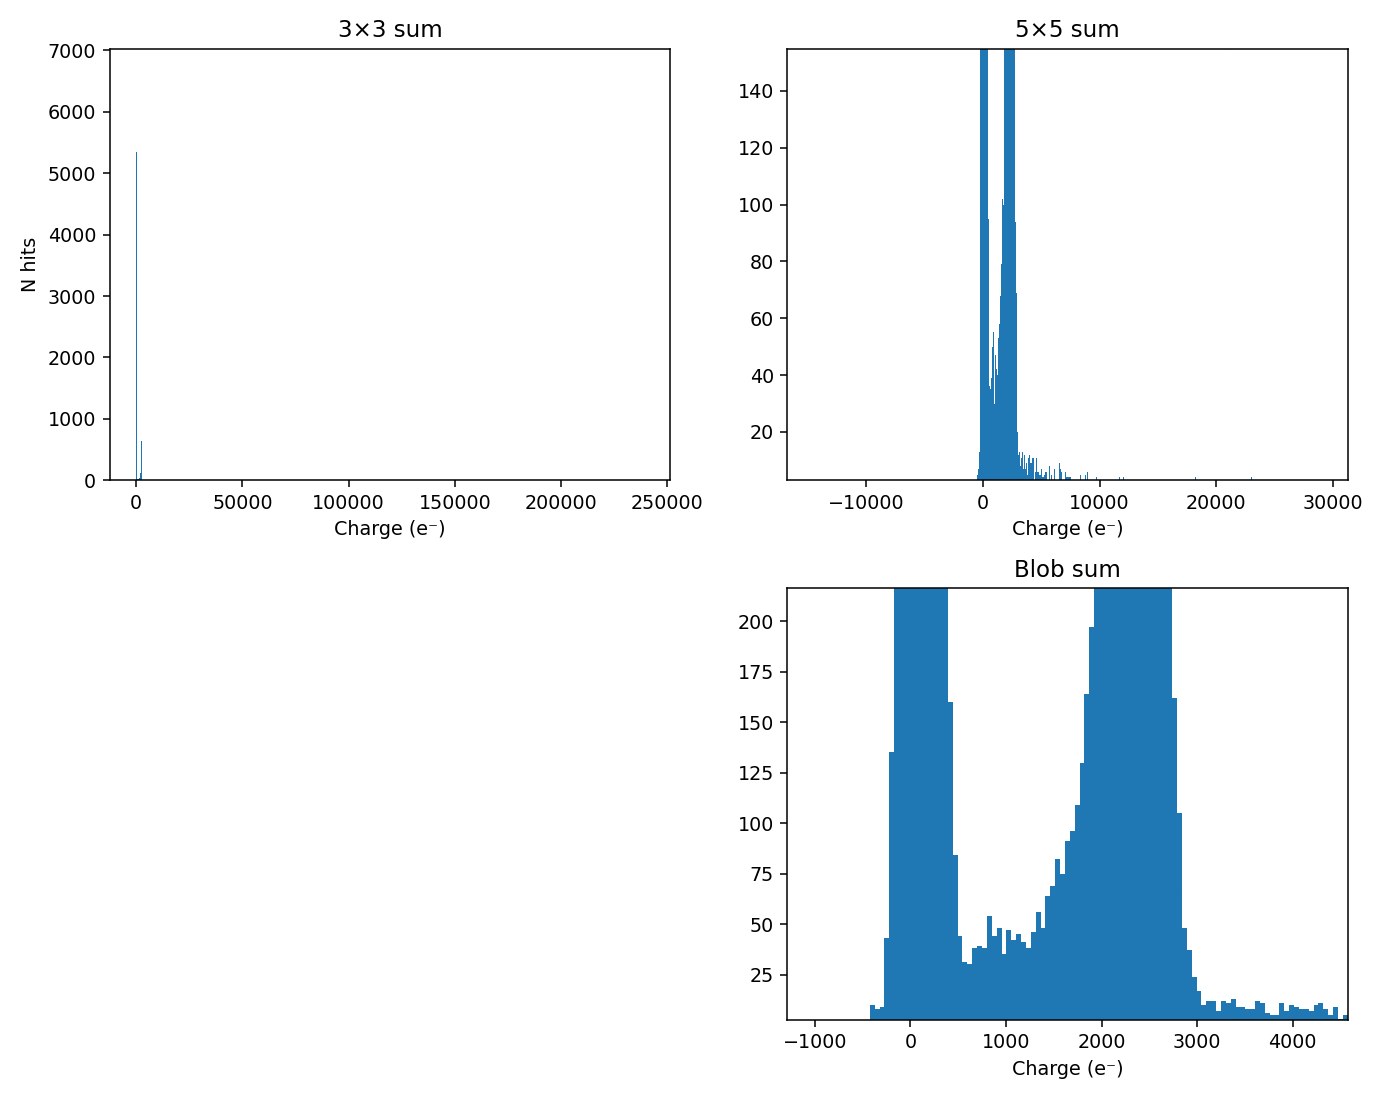

In [9]:
# Plot histograms in 2 rows × 2 cols ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()   # makes it easy to index: axes[0], axes[1], axes[2], axes[3]

# 3×3 sum
axes[0].hist(df['sum3x3_e⁻'], bins=10000, density = True)
axes[0].set(title='3×3 sum', xlabel='Charge (e⁻)', ylabel='N hits')

# 5×5 sum
axes[1].hist(df['sum5x5_e⁻'], bins=10000, density = True)
axes[1].set(title='5×5 sum', xlabel='Charge (e⁻)')

# Footprint sum
axes[2].axis('off')
#axes[2].hist(df['fp_e⁻'], bins=10000, density = True)
#axes[2].set(title='Footprint sum', xlabel='Charge (e⁻)')

# blob sum
axes[3].hist(df['blob_e⁻'], bins=10000, density = True)
axes[3].set(title='Blob sum', xlabel='Charge (e⁻)')

plt.tight_layout()
plt.show()

3×3_cut sum → μ = 2340.74 e⁻, σ = 124.10 e⁻, FWHM = 292.24 e⁻
5×5_cut sum → μ = 2358.02 e⁻, σ = 166.73 e⁻, FWHM = 392.61 e⁻
blob_cut sum → μ = 2357.68 e⁻, σ = 163.31 e⁻, FWHM = 384.56 e⁻


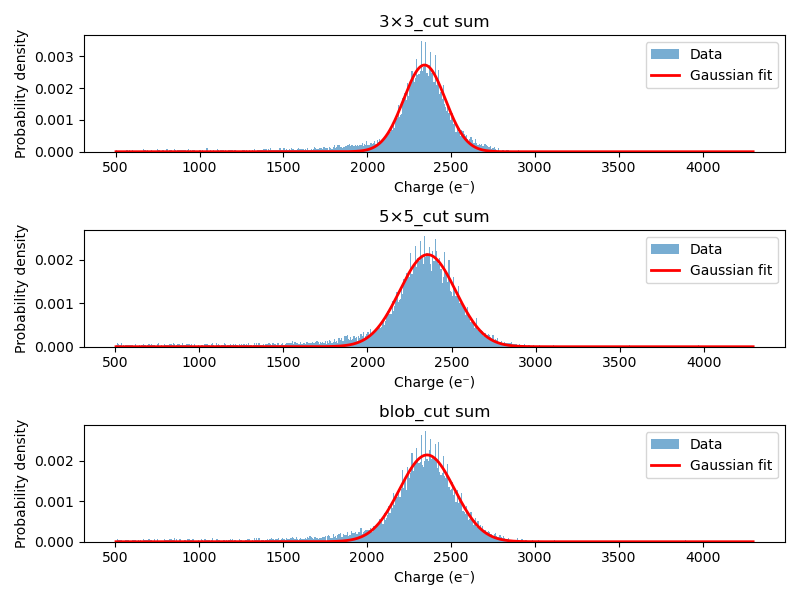

3x3 Data:   ⟨N⟩ = 2273.76, Var = 134047.54, Fano = 58.954
3x3 Fit:    ⟨N⟩ = 2340.74, Var = 124.10, Fano = 0.053

5x5 Data:   ⟨N⟩ = 2289.24, Var = 144092.20, Fano = 62.943
5x5 Fit:    ⟨N⟩ = 2358.02, Var = 166.73, Fano = 0.071

Blob Data:   ⟨N⟩ = 2289.33, Var = 142683.40, Fano = 62.325
Blob Fit:    ⟨N⟩ = 2357.68, Var = 163.31, Fano = 0.069



In [10]:
# Define cut range
cut_min = 500
cut_max = 4300

# Apply cuts to the 3×3 data
data_3x3 = df['sum3x3_e⁻']
data_3x3_cut = data_3x3[(data_3x3 >= cut_min) & (data_3x3 <= cut_max)]

three_mean_data = data_3x3_cut.mean()
three_var_data  = data_3x3_cut.var(ddof=0) 
three_fano_data = three_var_data / three_mean_data

# Apply cuts to the 5×5 data
data_5x5 = df['sum5x5_e⁻']
data_5x5_cut = data_5x5[(data_5x5 >= cut_min) & (data_5x5 <= cut_max)]

five_mean_data = data_5x5_cut.mean()
five_var_data  = data_5x5_cut.var(ddof=0)
five_fano_data = five_var_data / five_mean_data

# Apply cuts to the blob data
data_blob = df['blob_e⁻']
data_blob_cut = data_blob[(data_blob >= cut_min) & (data_blob <= cut_max)]

blob_mean_data = data_blob_cut.mean()
blob_var_data  = data_blob_cut.var(ddof=0) 
blob_fano_data = blob_var_data / blob_mean_data


num_of_bins = 550

def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

series = [
    ('3×3_cut sum', data_3x3_cut),
    ('5×5_cut sum', data_5x5_cut),
    ('blob_cut sum', data_blob_cut)
]

# make a figure with two subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
stats = []
for ax, (label, data_series) in zip(axes, series):
    # 1) build histogram
    counts, bin_edges = np.histogram(data_series, bins=num_of_bins, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # 2) initial guess [A, μ, σ]
    p0 = [counts.max(), data_series.mean(), data_series.std()]
    
    # 3) fit
    popt, _ = curve_fit(gaussian, bin_centers, counts, p0=p0)
    A_fit, mu_fit, sigma_fit = popt
    sigma_fit = abs(sigma_fit)
    
    # 4) FWHM
    fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma_fit
    
    # 5) print fit parameters
    print(f"{label:8s} → μ = {mu_fit:.2f} e⁻, σ = {sigma_fit:.2f} e⁻, FWHM = {fwhm:.2f} e⁻")
    stats.append((mu_fit,sigma_fit,fwhm))
    # 6) plot histogram + fit
    ax.hist(data_series, bins=num_of_bins, density=True, alpha=0.6, label='Data')
    x_fit = np.linspace(bin_edges[0], bin_edges[-1], 1000)
    ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', lw=2, label='Gaussian fit')
    ax.set(
        title=label,
        xlabel='Charge (e⁻)',
        ylabel='Probability density'
    )
    ax.legend()

plt.tight_layout()
plt.show()

three_mean_fit = stats[0][0]
three_var_fit = stats[0][1]
three_fano_fit = three_var_fit / three_mean_fit
five_mean_fit = stats[1][0]
five_var_fit = stats[1][1]
five_fano_fit = five_var_fit / five_mean_fit
blob_mean_fit = stats[2][0]
blob_var_fit = stats[2][1]
blob_fano_fit = blob_var_fit / blob_mean_fit

print(f"3x3 Data:   ⟨N⟩ = {three_mean_data:.2f}, Var = {three_var_data:.2f}, Fano = {three_fano_data:.3f}")
print(f"3x3 Fit:    ⟨N⟩ = {three_mean_fit:.2f}, Var = {three_var_fit:.2f}, Fano = {three_fano_fit:.3f}\n")

print(f"5x5 Data:   ⟨N⟩ = {five_mean_data:.2f}, Var = {five_var_data:.2f}, Fano = {five_fano_data:.3f}")
print(f"5x5 Fit:    ⟨N⟩ = {five_mean_fit:.2f}, Var = {five_var_fit:.2f}, Fano = {five_fano_fit:.3f}\n")

print(f"Blob Data:   ⟨N⟩ = {blob_mean_data:.2f}, Var = {blob_var_data:.2f}, Fano = {blob_fano_data:.3f}")
print(f"Blob Fit:    ⟨N⟩ = {blob_mean_fit:.2f}, Var = {blob_var_fit:.2f}, Fano = {blob_fano_fit:.3f}\n")

In [11]:
# Computing Fano factor from the raw data, via moments ---
# helper to compute Fano via moments
def fano_from_data(x):
    mean = np.mean(x)
    second_moment = np.mean(x**2)           # ⟨n²⟩
    return (second_moment - mean**2) / mean # (⟨n²⟩−⟨n⟩²)/⟨n⟩

three_fano_data = fano_from_data(data_3x3_cut.values)
five_fano_data  = fano_from_data(data_5x5_cut.values)
blob_fano_data  = fano_from_data(data_blob_cut.values)

print("Raw-data Fano factors:")
print(f"  3×3 → {three_fano_data:.3f}")
print(f"  5×5 → {five_fano_data:.3f}")
print(f" blob → {blob_fano_data:.3f}")

# --- 2) From your Gaussian fit, via moments ---
# For a Gaussian with mean=μ and σ, ⟨n²⟩ = μ² + σ²,
# so F = ( (μ²+σ²) − μ² ) / μ = σ²/μ — exactly the same result,
# but if you really want to write it in moment form:
def fano_from_fit(mu, sigma):
    second_moment = mu**2 + sigma**2
    return (second_moment - mu**2) / mu

# suppose stats[0] == (μ₃, σ₃, fwhm₃) for your 3×3 fit:
three_mu_fit2, three_sigma_fit2, _ = stats[0]
three_fano_fit2 = fano_from_fit(three_mu_fit2, three_sigma_fit2)

print("\nFit-derived Fano factor:")
print(f"  3×3 fit2 → {three_fano_fit2:.3f} vs fit → {three_fano_fit:.3f}")


Raw-data Fano factors:
  3×3 → 58.954
  5×5 → 62.943
 blob → 62.325

Fit-derived Fano factor:
  3×3 fit2 → 6.580 vs fit → 0.053


In [12]:
best_w = xray_en/blob_mean_fit
best_f_eff = blob_fano_fit

print(f"Best fit of w = {best_w:.3f}")
print(f"Best fit of F_eff = {best_f_eff:.3f}")

Best fit of w = 2.502
Best fit of F_eff = 0.069


Mean ionization events = 399.69180475829154, +/- 5.261667546691869


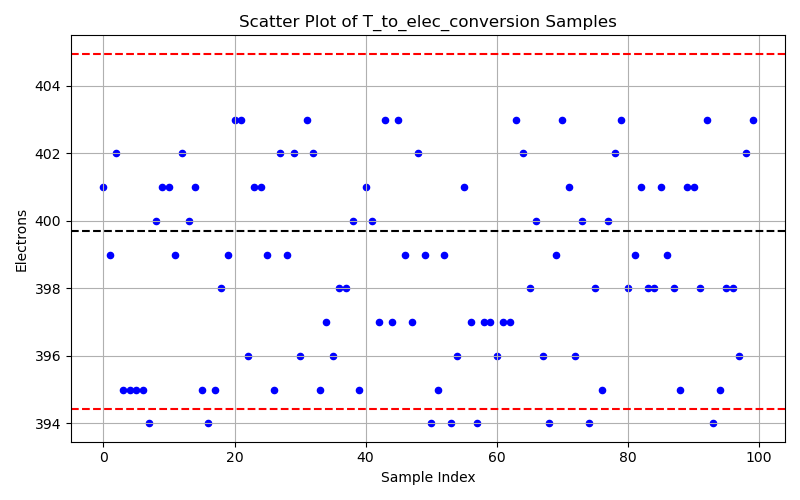

In [13]:
test_energy = 1000 # 1keV

def T_to_elec_conversion(T, f_eff, w):
    return np.random.randint((T/w) - np.sqrt((f_eff*T)/w), high=(T/w) + np.sqrt((f_eff*T)/w), dtype=int)

samples = [T_to_elec_conversion(test_energy, best_f_eff, best_w) for _ in range(100)]
#print(samples)

print(f"Mean ionization events = {test_energy/best_w}, +/- {np.sqrt((best_f_eff*test_energy)/best_w)}")

# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(range(len(samples)), samples, color='blue', s=20)
plt.axhline(y=1000/best_w, ls='--', color='k')
plt.axhline(y=1000/best_w - np.sqrt((best_f_eff*1000)/best_w), ls='--', color='r')
plt.axhline(y=1000/best_w + np.sqrt((best_f_eff*1000)/best_w), ls='--', color='r')
plt.title('Scatter Plot of T_to_elec_conversion Samples')
plt.xlabel('Sample Index')
plt.ylabel('Electrons')
plt.grid(True)
plt.tight_layout()
plt.show()